# MCBDD 2021 Module II offline activity 

Jitao David Zhang, June 2021

All the analysis below was done with python 3.8.5 using conda version 4.10.1.


## Task 1

Retrieve all approved drugs from the ChEMBL database, sort them by approval year and name. 

The following steps examine the first approval year and names of drugs, and fill a DataFrame with these information. While the first approval year is almost uniquely defined, a drug can have many names. For consistency, we use the INN (international nonproprietary names). See [chembl_webresource_client](https://github.com/chembl/chembl_webresource_client) for more examples.

In [1]:
from chembl_webresource_client.new_client import new_client
import requests
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
drugs = new_client.drug
len(drugs)

13721

In [3]:
drugs[0]

{'applicants': ['Mylan Pharmaceuticals Inc',
  'Idt Australia Ltd',
  'Ani Pharmaceuticals Inc',
  'Teva Pharmaceuticals Usa',
  'Pfizer Laboratories Div Pfizer Inc',
  'Ivax Pharmaceuticals Inc Sub Teva Pharmaceuticals Usa',
  'Watson Laboratories Inc',
  'Pfizer Inc',
  'American Therapeutics Inc',
  'Purepac Pharmaceutical Co'],
 'atc_classification': [{'code': 'C02CA01',
   'description': 'CARDIOVASCULAR SYSTEM: ANTIHYPERTENSIVES: ANTIADRENERGIC AGENTS, PERIPHERALLY ACTING: Alpha-adrenoreceptor antagonists'}],
 'availability_type': 1,
 'biotherapeutic': None,
 'black_box': False,
 'black_box_warning': '0',
 'chirality': 2,
 'development_phase': 4,
 'drug_type': 1,
 'first_approval': 1976,
 'first_in_class': False,
 'helm_notation': None,
 'indication_class': 'Antihypertensive',
 'molecule_chembl_id': 'CHEMBL2',
 'molecule_properties': {'alogp': '1.78',
  'aromatic_rings': 3,
  'cx_logd': '1.43',
  'cx_logp': '1.65',
  'cx_most_apka': None,
  'cx_most_bpka': '7.24',
  'full_molformu

In [4]:
def get_chembl(drug: list):
    """ return ChEMBL ID"""
    return drug['molecule_chembl_id']

get_chembl(drugs[0])

'CHEMBL2'

In [5]:
def get_FirstApproval(drug: list):
    """ returns the year of first approval"""
    return drug['first_approval']


get_FirstApproval(drugs[0])

1976

In [6]:
drugs[0]['molecule_synonyms']

[{'molecule_synonym': 'CP-12299',
  'syn_type': 'RESEARCH_CODE',
  'synonyms': 'CP-12299'},
 {'molecule_synonym': 'CP-122991',
  'syn_type': 'RESEARCH_CODE',
  'synonyms': 'CP-122991'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'FDA', 'synonyms': 'Prazosin'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'ATC', 'synonyms': 'PRAZOSIN'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'BAN', 'synonyms': 'PRAZOSIN'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'INN', 'synonyms': 'PRAZOSIN'},
 {'molecule_synonym': 'Prazosin',
  'syn_type': 'MERCK_INDEX',
  'synonyms': 'PRAZOSIN'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'OTHER', 'synonyms': 'PRAZOSIN'}]

In [7]:
def get_INN(drug: list):
    """returns INN name, use ; as concatenator if more than one value is available"""
    inn = [x['molecule_synonym'] for x in drug['molecule_synonyms'] if x['syn_type'] == 'INN']
    res = ';'.join(inn)
    return(res)


get_INN(drugs[0])

'Prazosin'

In [8]:
ids = [get_chembl(x) for x in drugs]
years = [get_FirstApproval(x) for x in drugs]
names = [get_INN(x) for x in drugs]

In [9]:
task1 = pd.DataFrame({'ID':ids, 'Name':names, 'FirstApproval':years})
task1.sort_values(by=['Name', 'FirstApproval'], axis=0, inplace=True)
print(task1)
## notice that not all molecules have INN names or approval information

                  ID               Name  FirstApproval
263         CHEMBL90                            1939.0
1056       CHEMBL821                            1939.0
2873       CHEMBL190                            1940.0
4535   CHEMBL1201649                            1942.0
4250   CHEMBL1201235                            1943.0
...              ...                ...            ...
2444    CHEMBL167779        Zuclomifene            NaN
1304     CHEMBL53904     Zuclopenthixol            NaN
12335  CHEMBL4105630         Zuranolone            NaN
12780  CHEMBL4297637  Zuretinol acetate            NaN
12115  CHEMBL3989838       Zylofuramine            NaN

[13721 rows x 3 columns]


In [10]:
task1.to_csv('20210613-ChEMBL-drugs-sorted-by-name-and-approval.tsv.gz', sep='\t')

## Task 2

For each approved drug since 2011 that you identified in step (1), retrieve a list of UniProt accession numbers, namely protein targets associated with the drug.

We first filter the compounds by the approval year.

In [11]:
approved_s2011_df = task1.query('FirstApproval >= 2011')\
                         .sort_values(by='FirstApproval', axis=0)
print(approved_s2011_df)

                  ID                  Name  FirstApproval
3164    CHEMBL271227                               2011.0
5208   CHEMBL1628502  Gabapentin enacarbil         2011.0
10676  CHEMBL2218860            Gadobutrol         2011.0
5465   CHEMBL1742994   Brentuximab vedotin         2011.0
2573    CHEMBL439849            Vilazodone         2011.0
...              ...                   ...            ...
11824  CHEMBL3833307          Satralizumab         2020.0
13282  CHEMBL4298187  Ferric derisomaltose         2020.0
10667  CHEMBL2205807            Abametapir         2020.0
7071   CHEMBL2105248                               2020.0
12170  CHEMBL3989949            Cenobamate         2020.0

[421 rows x 3 columns]


Next we query UniProts of targets associated with each drug molecule. The query is done in two steps: first we find ChEMBL identifiers of targets, and then we translate these ChEMBL identifiers to UniProt identifiers.

To save time, I used only the first 50 drugs to produce the example below. Even this is quite slow, taking quite a few minutes to run. You are welcome to use all compounds as input if you are interested in the results. 

Some technical detail: queries are done in so-called chunks, with 25 items in a chunk and therefore we use two chunks in total. The use of chunks help to limite the information transmitted between the server and the client, and thereby reducing both server load and client's waiting time. If you wish to process all compounds (counted 421 as of 13th June 2021), you can use a larger chunk size, for instance 50.

In [12]:
drugs_approved_s2021 = approved_s2011_df.ID[0:50]

comp2target = dict()
for d in drugs_approved_s2021:
    comp2target[d] = set()

# Process compounds in chunks so that we prevent huge queries:
chunk_size = 25
keys = list(comp2target.keys())

for i in range(0, len(keys), chunk_size):
    # we jump from compounds to targets through activities:
    activities = new_client.activity.filter(molecule_chembl_id__in=keys[i:i + chunk_size]).only(
        ['molecule_chembl_id', 'target_chembl_id'])
    # extracting target ChEMBL IDs from activities:
    for act in activities:
        comp2target[act['molecule_chembl_id']].add(act['target_chembl_id'])

# Now our dictionary maps from compound ChEMBL IDs into target ChEMBL IDs
# We next translate the identifier of targets from ChEMBL IDs to UniProt IDs
for key, val in comp2target.items():
    # We don't know how many targets are associated with any compound. Therefore it is
    # better to process targets in chunks, as suggested by the ChEMBL webclient.
    lval = list(val)
    uniprots = set()
    for i in range(0, len(val), chunk_size):
        targets = new_client.target.filter(target_chembl_id__in=lval[i:i + chunk_size]).only(
            ['target_components'])
        uniprots |= {comp['accession'] for t in targets for comp in t['target_components']}

    comp2target[key] = uniprots

In [13]:
comp2target_df = pd.DataFrame([(i, uniprot) for i, j in comp2target.items() for uniprot in j], 
                  columns=['ID','UniProt'])
print(comp2target_df)

                 ID UniProt
0      CHEMBL271227  P10275
1      CHEMBL271227  P05093
2      CHEMBL271227  P0DTD1
3     CHEMBL1628502  P0DTD1
4     CHEMBL2218860  P0DTD1
...             ...     ...
3253  CHEMBL1082407  P15207
3254  CHEMBL1082407  O60885
3255  CHEMBL1082407  Q9UBN7
3256  CHEMBL1082407  P05093
3257  CHEMBL1082407  P0DTD1

[3258 rows x 2 columns]


Here we report *all* targets, irrespective of assays and affinicities. In reality, you may be more interested in specific targets with high affinities. In such situations, it makes sense to se one or more filters that fit your purpose.

Finally we export the results into a tab-delimited file again.

In [14]:
comp2target_df.to_csv('20210613-ChEMBL-drugs-since-2011-UniProt.tsv.gz', sep='\t')

## Task 3

For each protein with a UniProt accession number that you identified in step (2),retrieve UniProt keywords associated with it.

Again, for the purpose of demonstration, I show the analysis with the first 100 proteins. I used the REST API of UniProt to show how it works, which accepts maximum 100 proteins in one go, that's why I retrieved the keywords of 100 proteins. Similar as what we did before with the ChEMBL database, you can break up big queries into smaller chunks.

You can try to query all other proteins with the same procedure. However, for effective use when you have many identifiers, it may make more sense to bulk-download the keyword data from UniProt and run the analysis.

In [15]:
## read in results of task 2
task2_res = pd.read_csv('20210613-ChEMBL-drugs-since-2011-UniProt.tsv.gz', sep='\t', index_col=0)

In [16]:
uniq_uniprot = set(task2_res.UniProt)
sel_uniprot = list(uniq_uniprot)[:100]
sel_uniprot_queryid = ','.join(sel_uniprot)

In [17]:
## see UniProt API document here: https://www.ebi.ac.uk/proteins/api/doc/#!/proteins/search
url = 'https://www.ebi.ac.uk/proteins/api/proteins?offset=0&size=100&accession='+sel_uniprot_queryid
r = requests.get(url, headers={'Accept': 'application/json'})

In [18]:
## the keywords of the first protein can be found here
keywords = [list(k.values())[0] for k in r.json()[0]['keywords']]
print(keywords)

['ATP-binding', 'Cell membrane', 'Cytoplasm', 'Endoplasmic reticulum', 'Kinase', 'Membrane', 'Microsome', 'Nucleotide-binding', 'Nucleus', 'Reference proteome', 'Transferase']


In [19]:
len(r.json())

100

In [20]:
## now let's try to fetch all keywords
def get_keywords(protein: list):
    res = [list(k.values())[0] for k in protein['keywords']]
    if res == None:
        res = []
    return(res)

all_keywords=[]
for jlist in r.json():
    all_keywords.extend(get_keywords(jlist))
    
keyword_counter = Counter(all_keywords)
print(keyword_counter)

Counter({'Reference proteome': 97, '3D-structure': 73, 'Phosphoprotein': 73, 'Nucleotide-binding': 59, 'Transferase': 58, 'Alternative splicing': 58, 'ATP-binding': 57, 'Kinase': 50, 'Membrane': 47, 'Cytoplasm': 46, 'Serine/threonine-protein kinase': 36, 'Metal-binding': 36, 'Cell membrane': 31, 'Nucleus': 30, 'Transmembrane': 29, 'Transmembrane helix': 29, 'Glycoprotein': 27, 'Disease variant': 26, 'Repeat': 25, 'Direct protein sequencing': 23, 'Disulfide bond': 22, 'Ubl conjugation': 21, 'Magnesium': 20, 'Tyrosine-protein kinase': 19, 'Signal': 19, 'Acetylation': 19, 'Receptor': 19, 'Hydrolase': 15, 'Zinc': 12, 'Endoplasmic reticulum': 11, 'Transcription': 11, 'Transcription regulation': 11, 'Lipoprotein': 11, 'Apoptosis': 9, 'Chromatin regulator': 8, 'Cytoskeleton': 8, 'Methylation': 8, 'G-protein coupled receptor': 8, 'Transducer': 8, 'Isopeptide bond': 7, 'Cell cycle': 7, 'Palmitate': 7, 'Cell junction': 7, 'Microsome': 6, 'Developmental protein': 6, 'Transport': 6, 'Chromosomal r

We visualize the most common 20 keywords with a histogram.

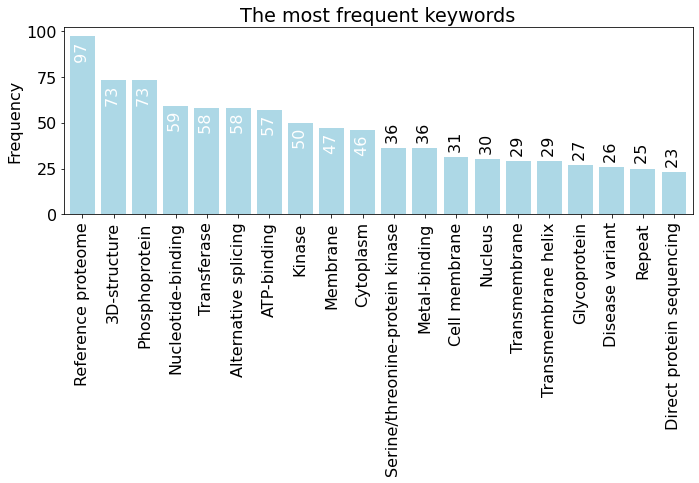

In [21]:
most_common_keywords = keyword_counter.most_common(20)
y = [count for keyword, count in most_common_keywords]
x = [keyword for keyword, count in most_common_keywords]

plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams.update({'font.size': 16})

plt.bar(x, y, color='lightblue')
plt.title("The most frequent keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(most_common_keywords):
    plt.text(i, count, f' {count} ', rotation=90, size=16,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

Note that many proteins are annotated with the keyword 'kinase' and 'membrane proteins' (especially 'receptor'), which are expected because these are the most frequent drug targets.